In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import learning_curve


In [2]:
# dataset https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data
df = pd.read_csv('Housing.csv') # import data from kaggle input

In [3]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [6]:
df.shape

(545, 13)

### All duplicated values

In [7]:
df.duplicated().sum()

0

### All null values

In [8]:
df.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

/Users/bochnak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


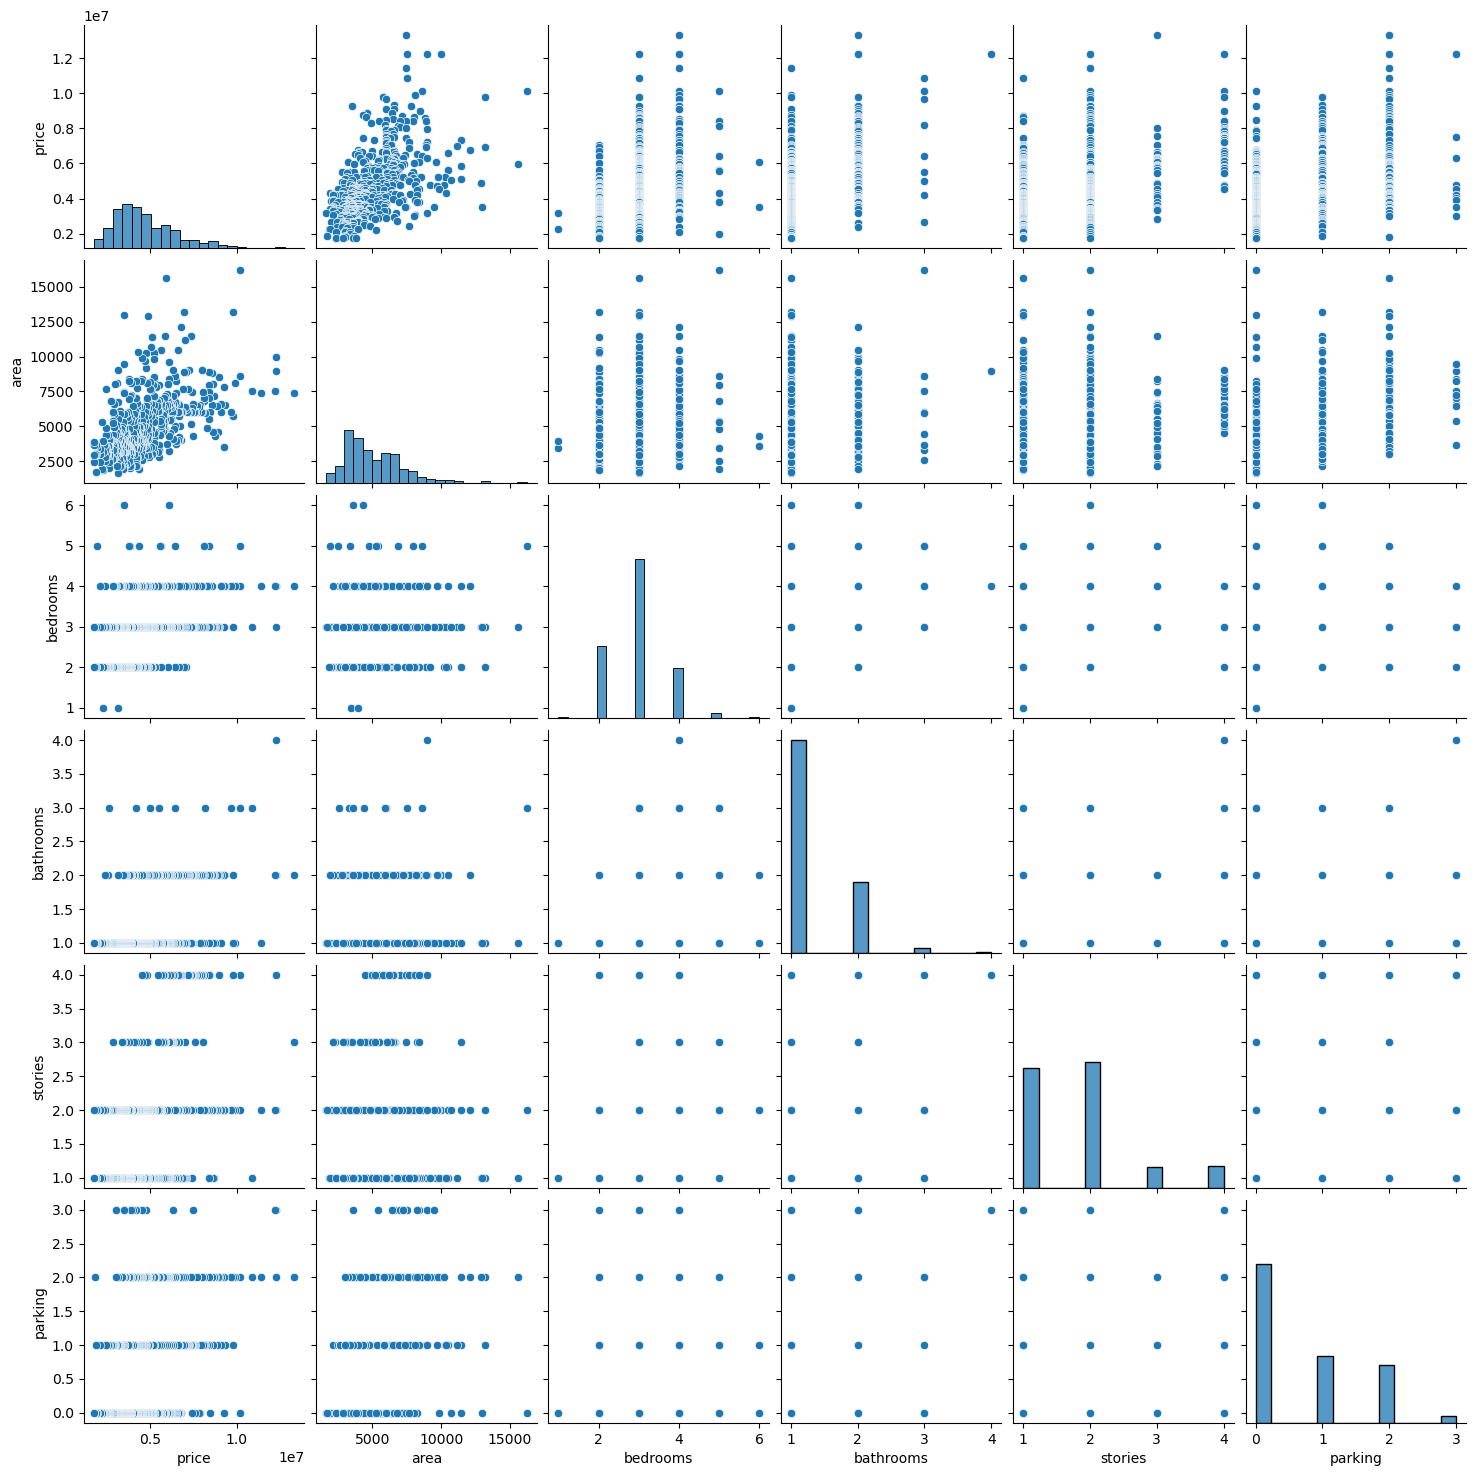

In [9]:
sns.pairplot(df)

/var/folders/km/vd961byj21d2vgpgtcvkn3940000gn/T/ipykernel_30267/436200501.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.price)


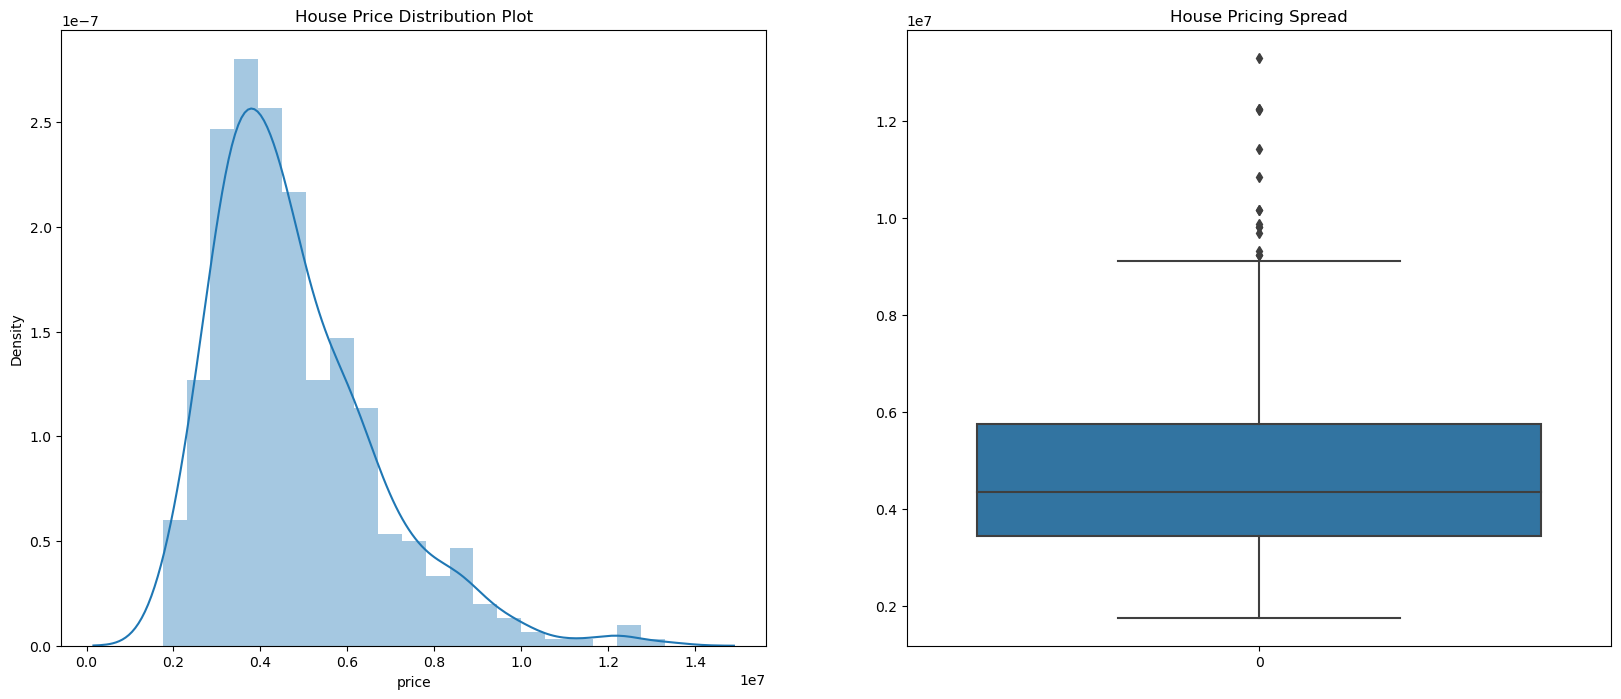

In [10]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('House Price Distribution Plot')
sns.distplot(df.price)

plt.subplot(1,2,2)
sns.boxplot(df.price)
plt.title('House Pricing Spread')

plt.show()


### Correlation of price with numerical columns

In [11]:
object_columns = [x for x in df.columns if df[x].dtype == 'object']

In [12]:
object_columns

['mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'prefarea',
 'furnishingstatus']

In [13]:
corr_matrix = df[[x for x in df.columns if x not in object_columns]].corr()

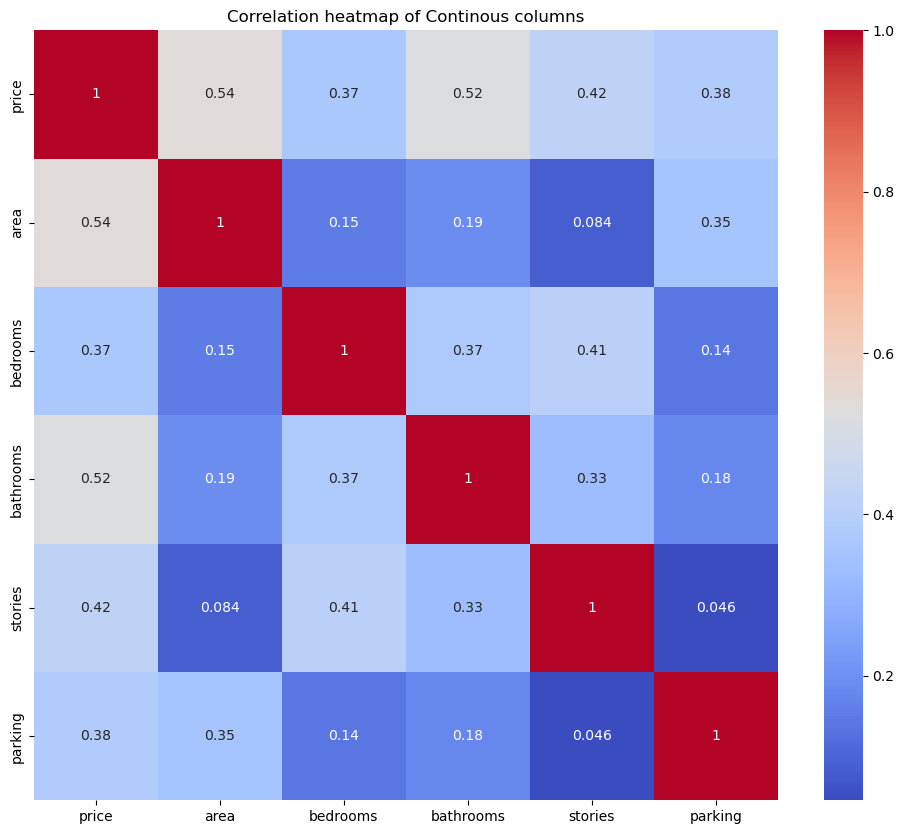

In [14]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap of Continous columns')
plt.show()

### Correlation of price with numerical columns

In [15]:
# Initialize LabelEncoder
le = LabelEncoder()

# furnishingstatus is categorical nominal
furnishingstatus_categories = df['furnishingstatus'].unique()

# Fit and transform
encoded_values = le.fit_transform(furnishingstatus_categories)

# Print the mapping
print("LabelEncoder Mapping for furnishingstatus:")
for category, encoded_value in zip(furnishingstatus_categories, encoded_values):
    print(f"{category} -> {encoded_value}")

LabelEncoder Mapping for furnishingstatus:
furnished -> 0
semi-furnished -> 1
unfurnished -> 2


In [16]:
correlation_results = {}
p_values = {}

for column in object_columns:
    # Fit transform 
    df[column] = le.fit_transform(df[column])
    
    correlation, p_value = stats.pointbiserialr(df[column], df['price'])

    correlation_results[column] = correlation
    p_values[column] = p_value

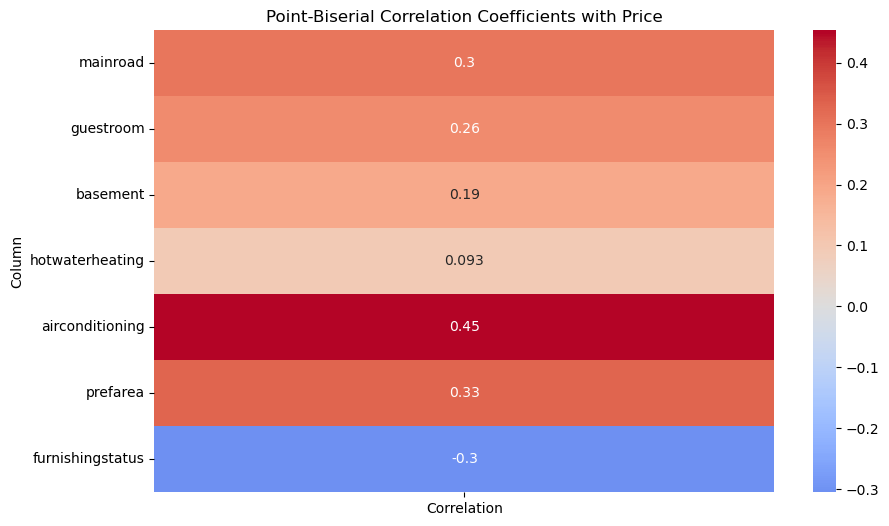

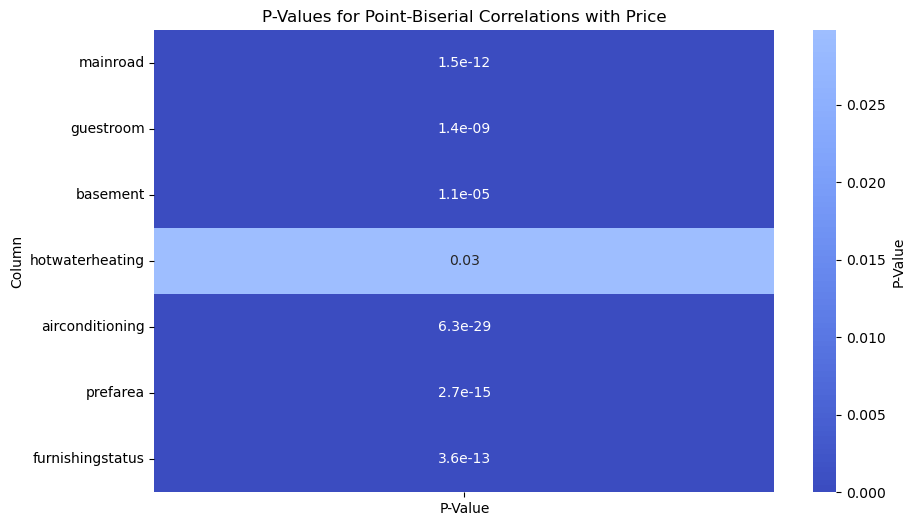

In [17]:
# Convert the correlation results to a DataFrame for heatmap
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Column', 'Correlation'])
correlation_df.set_index('Column', inplace=True)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
plt.title('Point-Biserial Correlation Coefficients with Price')
plt.show()


# Convert the p-values to a DataFrame
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Column', 'P-Value'])
p_values_df.set_index('Column', inplace=True)

# Plotting the p-values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(p_values_df, annot=True, cmap='coolwarm', center=0.05, cbar_kws={'label': 'P-Value'})
plt.title('P-Values for Point-Biserial Correlations with Price')
plt.show()

In [18]:
df.furnishingstatus

0      0
1      0
2      1
3      0
4      0
      ..
540    2
541    1
542    2
543    0
544    2
Name: furnishingstatus, Length: 545, dtype: int64

In [19]:
X = df.drop('price', axis=1)
y = df['price']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
def plot_grid_search_results(grid, param_name, model_name):
    params = [str(params[param_name]) for params in grid.cv_results_['params']]
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']

    plt.figure(figsize=(10, 6))
    plt.errorbar(params, means, yerr=stds, fmt='o', capsize=5)
    plt.title(f'Grid Search Results for {model_name}')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
# Function to plot learning curves
def plot_learning_curves(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = -train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = -test_scores.std(axis=1)

    plt.figure(figsize=(10, 8))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.title('Learning Curves')
    plt.xlabel('Training examples')
    plt.ylabel('MSE')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [23]:
# Define pipeline for Linear Regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

# Define parameters for grid search
params_lr = {
    'reg__fit_intercept': [True, False],
    'reg__positive': [True, False]
}

# Perform grid search with cross-validation
grid_lr = GridSearchCV(pipeline_lr, params_lr, cv=10, scoring='neg_mean_squared_error')
grid_lr.fit(X_train, y_train)

# Extract best parameters and evaluate on test set
best_model_lr = grid_lr.best_estimator_
y_pred_train_lr = best_model_lr.predict(X_train)
y_pred_test_lr = best_model_lr.predict(X_test)

mse_train_lr = mean_squared_error(y_train, y_pred_train_lr)
mse_test_lr = mean_squared_error(y_test, y_pred_test_lr)

print(f'Best Parameters: {grid_lr.best_params_}')
print(f'Linear Regression MSE Train: {mse_train_lr:.2f}, MSE Test: {mse_test_lr:.2f}')

Best Parameters: {'reg__fit_intercept': True, 'reg__positive': False}
Linear Regression MSE Train: 965153171508.67, MSE Test: 1535047758428.05


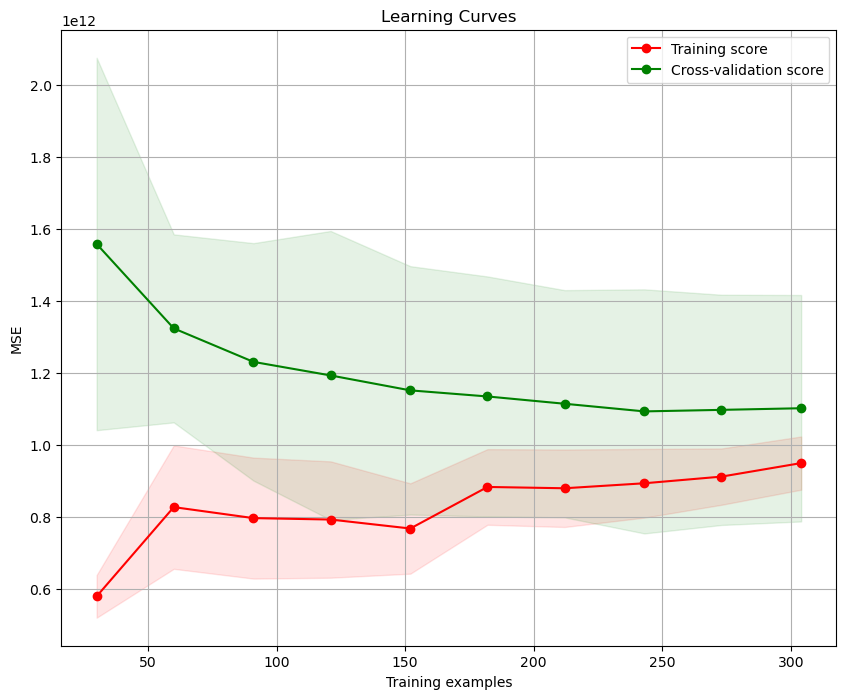

In [24]:
# Plot learning curves for the best linear regression model
plot_learning_curves(best_model_lr, X_train, y_train)

In [25]:
# Define pipeline for Decision Tree Regressor
pipeline_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', DecisionTreeRegressor(random_state=42))
])

# Define parameters for grid search
params_tree = {
    'reg__max_depth': [None, 10, 20, 30],
    'reg__min_samples_split': [2, 10, 20],
    'reg__min_samples_leaf': [1, 5, 10]
}

# Perform grid search with cross-validation
grid_tree = GridSearchCV(pipeline_tree, params_tree, cv=10, scoring='neg_mean_squared_error')
grid_tree.fit(X_train, y_train)

# Extract best parameters and evaluate on test set
best_model_tree = grid_tree.best_estimator_
y_pred_train_tree = best_model_tree.predict(X_train)
y_pred_test_tree = best_model_tree.predict(X_test)

mse_train_tree = mean_squared_error(y_train, y_pred_train_tree)
mse_test_tree = mean_squared_error(y_test, y_pred_test_tree)

print(f'Best Parameters: {grid_tree.best_params_}')
print(f'Decision Tree MSE Train: {mse_train_tree:.2f}, MSE Test: {mse_test_tree:.2f}')

Best Parameters: {'reg__max_depth': None, 'reg__min_samples_leaf': 5, 'reg__min_samples_split': 20}
Decision Tree MSE Train: 864075369372.26, MSE Test: 2312027615468.56


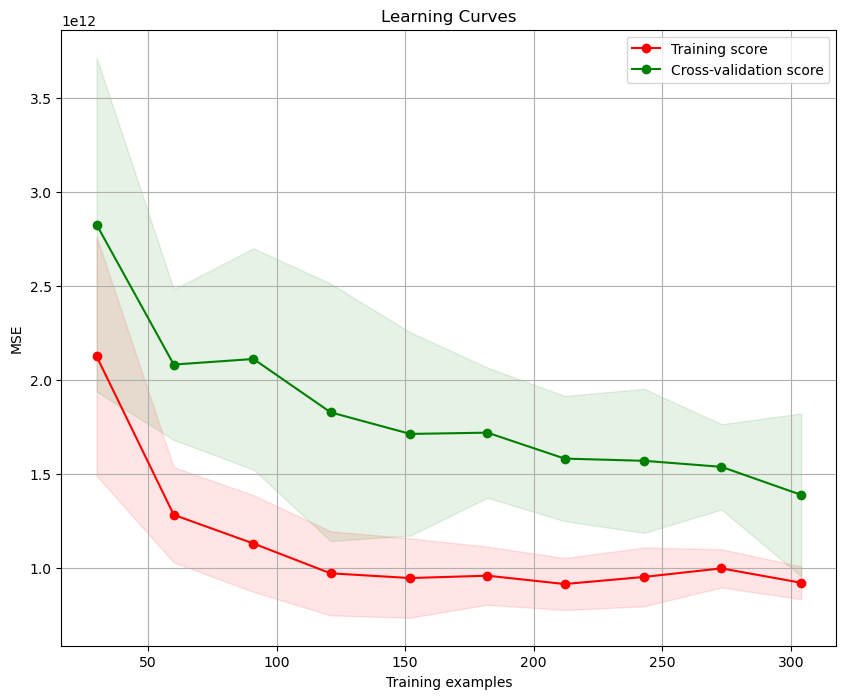

In [26]:
# Plot learning curves for the best Regre
plot_learning_curves(best_model_tree, X_train, y_train)

## Classification

In [27]:
np.median(y)

4340000.0

In [28]:
threshold = np.median(y)
y_binary = (y > threshold).astype(int)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

In [30]:
# Define pipeline and parameters for Logistic Regression
pipeline_log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

params_log_reg = {
    'clf__penalty': ['l2'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
}

# Define pipeline and parameters for Decision Tree Classifier
pipeline_tree_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

params_tree_clf = {
    'clf__max_depth': [3, 5, 10, None],
    'clf__min_samples_split': [2, 10, 20],
}

# Define pipeline and parameters for Random Forest Classifier
pipeline_rf_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

params_rf_clf = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [3, 5, 10, None],
    'clf__min_samples_split': [2, 10, 20],
}

# Define pipeline and parameters for XGBoost Classifier
pipeline_xgb_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(random_state=42))
])

params_xgb_clf = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 5, 10],
}


In [31]:
def perform_grid_search(pipeline, params, X_train, y_train):
    grid_search = GridSearchCV(pipeline, params, cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search

# Logistic Regression
grid_log_reg = perform_grid_search(pipeline_log_reg, params_log_reg, X_train, y_train)
best_model_log_reg = grid_log_reg.best_estimator_
y_pred_train_log = best_model_log_reg.predict(X_train)
y_pred_test_log = best_model_log_reg.predict(X_test)
accuracy_train_log = accuracy_score(y_train, y_pred_train_log)
accuracy_test_log = accuracy_score(y_test, y_pred_test_log)

# Decision Tree
grid_tree_clf = perform_grid_search(pipeline_tree_clf, params_tree_clf, X_train, y_train)
best_model_tree_clf = grid_tree_clf.best_estimator_
y_pred_train_tree_clf = best_model_tree_clf.predict(X_train)
y_pred_test_tree_clf = best_model_tree_clf.predict(X_test)
accuracy_train_tree_clf = accuracy_score(y_train, y_pred_train_tree_clf)
accuracy_test_tree_clf = accuracy_score(y_test, y_pred_test_tree_clf)

# Random Forest
grid_rf_clf = perform_grid_search(pipeline_rf_clf, params_rf_clf, X_train, y_train)
best_model_rf_clf = grid_rf_clf.best_estimator_
y_pred_train_rf = best_model_rf_clf.predict(X_train)
y_pred_test_rf = best_model_rf_clf.predict(X_test)
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

# XGBoost
grid_xgb_clf = perform_grid_search(pipeline_xgb_clf, params_xgb_clf, X_train, y_train)
best_model_xgb_clf = grid_xgb_clf.best_estimator_
y_pred_train_xgb = best_model_xgb_clf.predict(X_train)
y_pred_test_xgb = best_model_xgb_clf.predict(X_test)
accuracy_train_xgb = accuracy_score(y_train, y_pred_train_xgb)
accuracy_test_xgb = accuracy_score(y_test, y_pred_test_xgb)

print(f'Best Parameters Logistic Regression: {grid_log_reg.best_params_}')
print(f'Logistic Regression Accuracy Train: {accuracy_train_log}, Accuracy Test: {accuracy_test_log}')

print(f'Best Parameters Decision Tree: {grid_tree_clf.best_params_}')
print(f'Decision Tree Accuracy Train: {accuracy_train_tree_clf}, Accuracy Test: {accuracy_test_tree_clf}')

print(f'Best Parameters Random Forest: {grid_rf_clf.best_params_}')
print(f'Random Forest Accuracy Train: {accuracy_train_rf}, Accuracy Test: {accuracy_test_rf}')

print(f'Best Parameters XGBoost: {grid_xgb_clf.best_params_}')
print(f'XGBoost Accuracy Train: {accuracy_train_xgb}, Accuracy Test: {accuracy_test_xgb}')


Best Parameters Logistic Regression: {'clf__C': 0.1, 'clf__penalty': 'l2'}
Logistic Regression Accuracy Train: 0.8372703412073491, Accuracy Test: 0.8353658536585366
Best Parameters Decision Tree: {'clf__max_depth': 3, 'clf__min_samples_split': 20}
Decision Tree Accuracy Train: 0.800524934383202, Accuracy Test: 0.7134146341463414
Best Parameters Random Forest: {'clf__max_depth': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Random Forest Accuracy Train: 0.8740157480314961, Accuracy Test: 0.7987804878048781
Best Parameters XGBoost: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200}
XGBoost Accuracy Train: 0.958005249343832, Accuracy Test: 0.8414634146341463


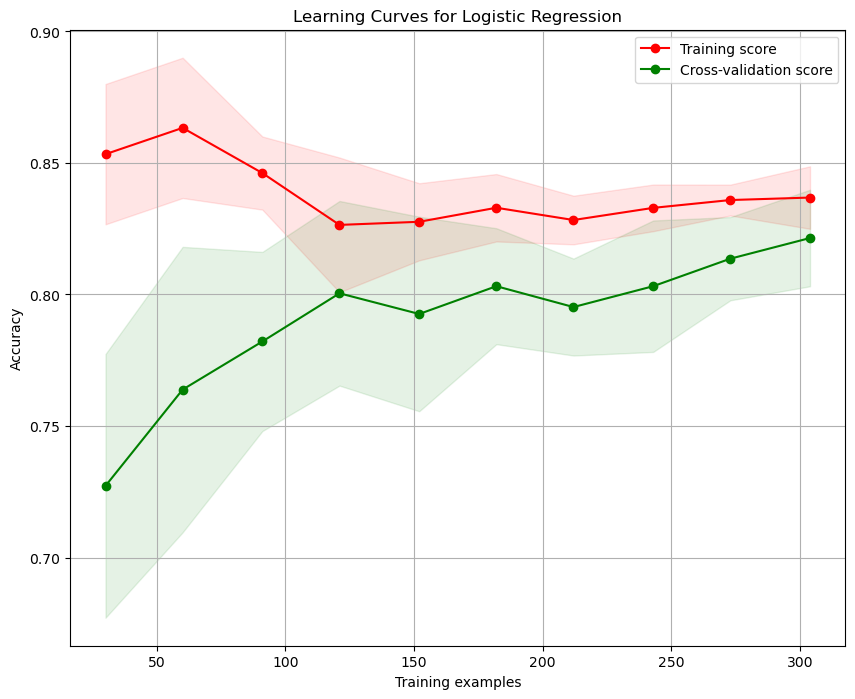

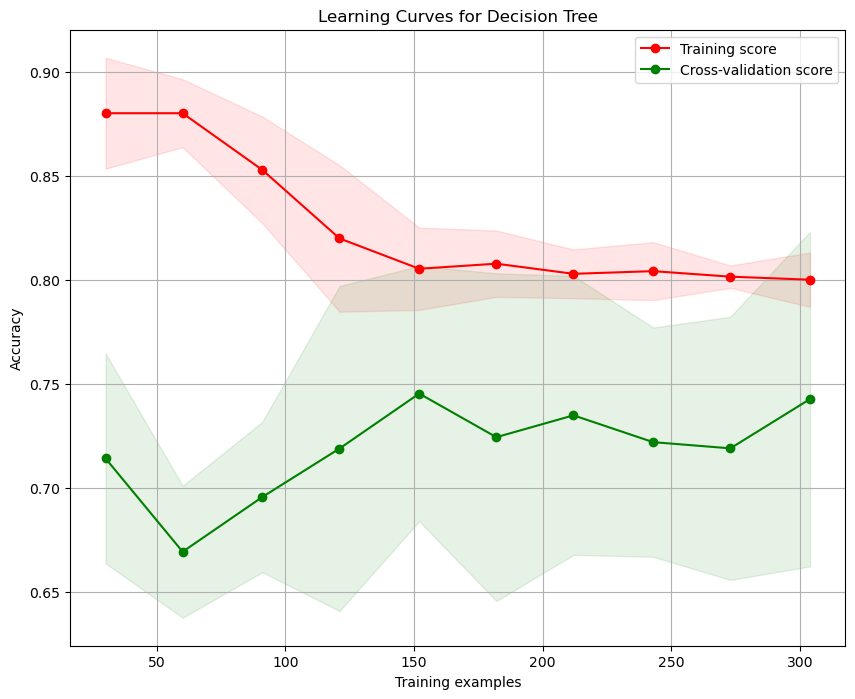

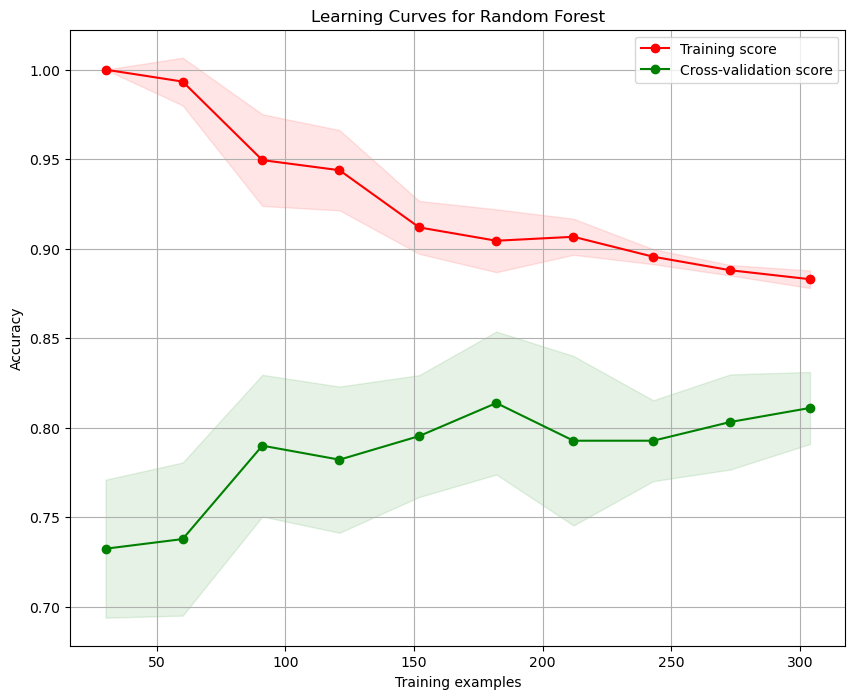

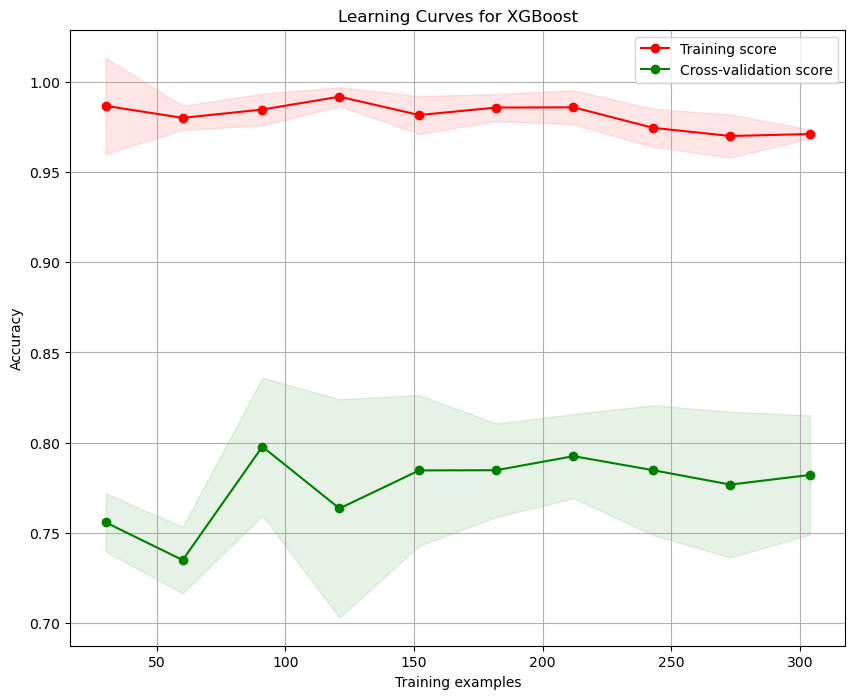

In [32]:
def plot_learning_curves(estimator, X_train, y_train, X_test, y_test, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.figure(figsize=(10, 8))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.title('Learning Curves for ' + title )
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot learning curves for the best models
plot_learning_curves(best_model_log_reg, X_train, y_train, X_test, y_test,'Logistic Regression')
plot_learning_curves(best_model_tree_clf, X_train, y_train, X_test, y_test, 'Decision Tree')
plot_learning_curves(best_model_rf_clf, X_train, y_train, X_test, y_test, 'Random Forest')
plot_learning_curves(best_model_xgb_clf, X_train, y_train, X_test, y_test, 'XGBoost')